# Задание

1. 
Выберите ряд из первого задани

2. Постройте его модель ARIMA.

3. Оформите отчёт в Jupyter-ноутбук.им ML.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

<Axes: >

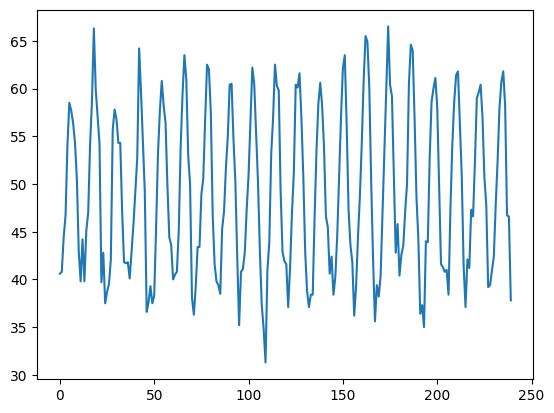

In [4]:
ts = pd.read_csv('Series/mean-monthly-air-temperature-deg.csv')['Deg']
ts.plot()

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


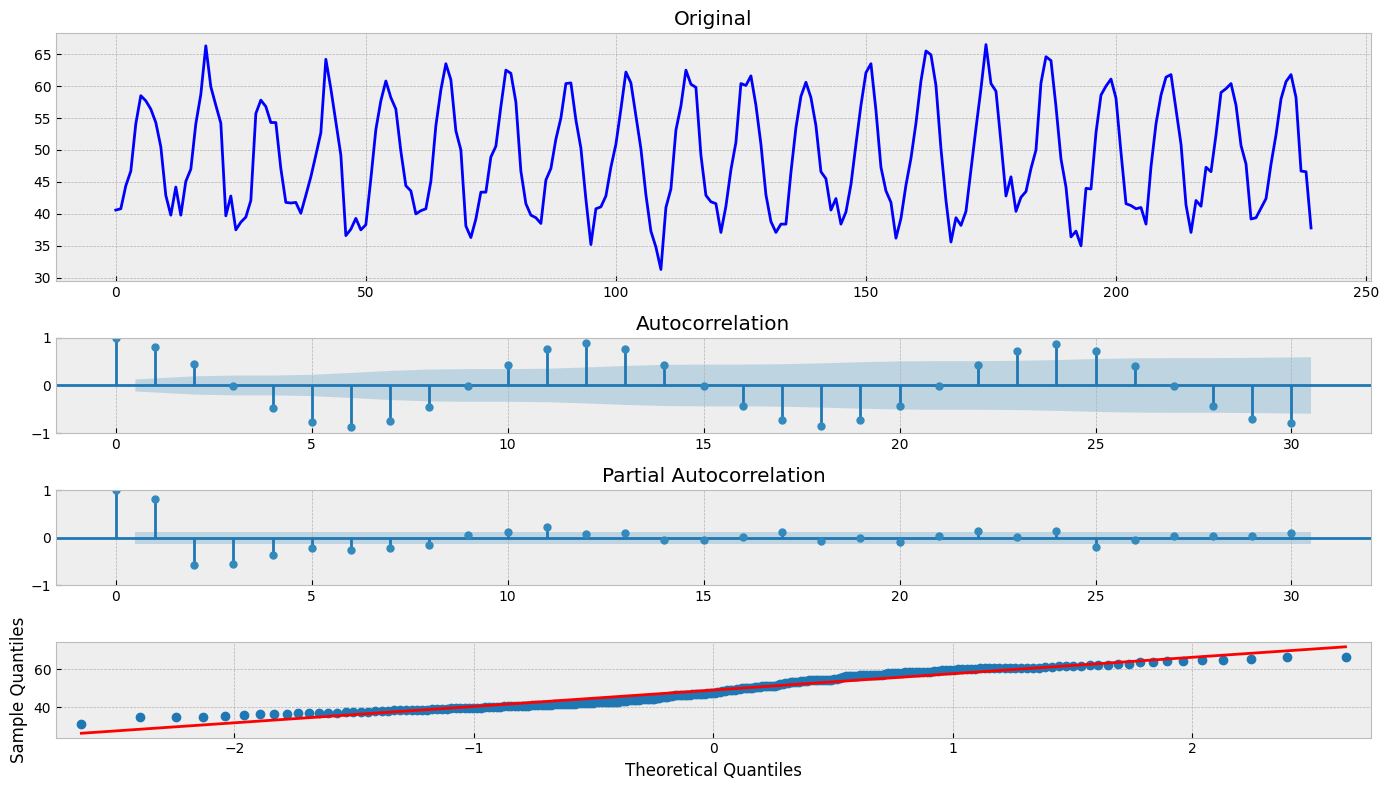

In [5]:
tsplot(ts, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                -6.390511e+00
p-value                        2.111642e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


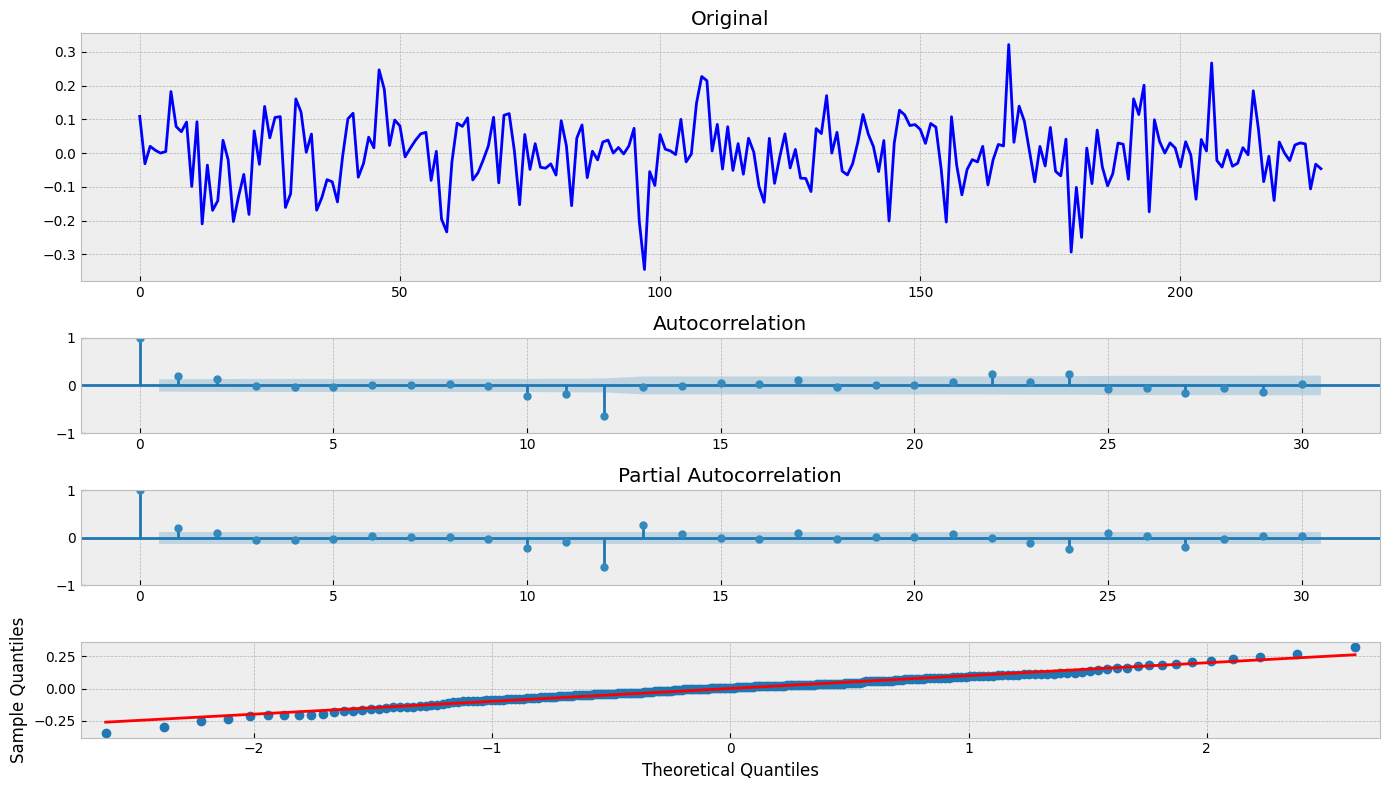

In [13]:
bc_ts, lmbda = boxcox(ts)
ts_diffed = bc_ts[12:] - bc_ts[:-12]
tsplot(ts_diffed, lags=30)

aic: -436.10720 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -5.427236
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


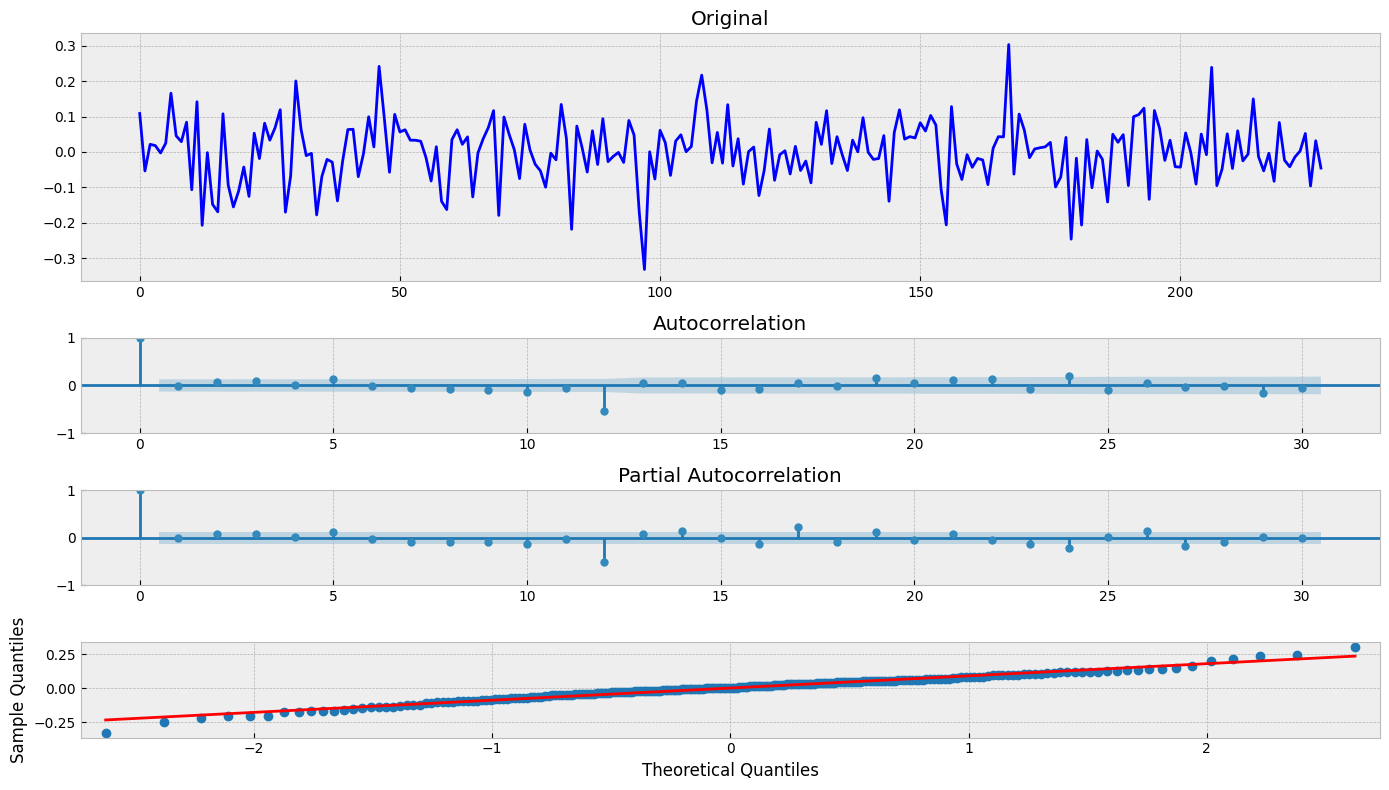

In [14]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(ts_diffed, order=(i,d,j), trend='n').fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [16]:
def restore_ts(ts_diffed, bc_ts, lmbda):
    return boxcox(ts_diffed + bc_ts[:-12], lmbda=lmbda)

Results of Dickey-Fuller Test:
Test Statistic                  -3.644991
p-value                          0.004957
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


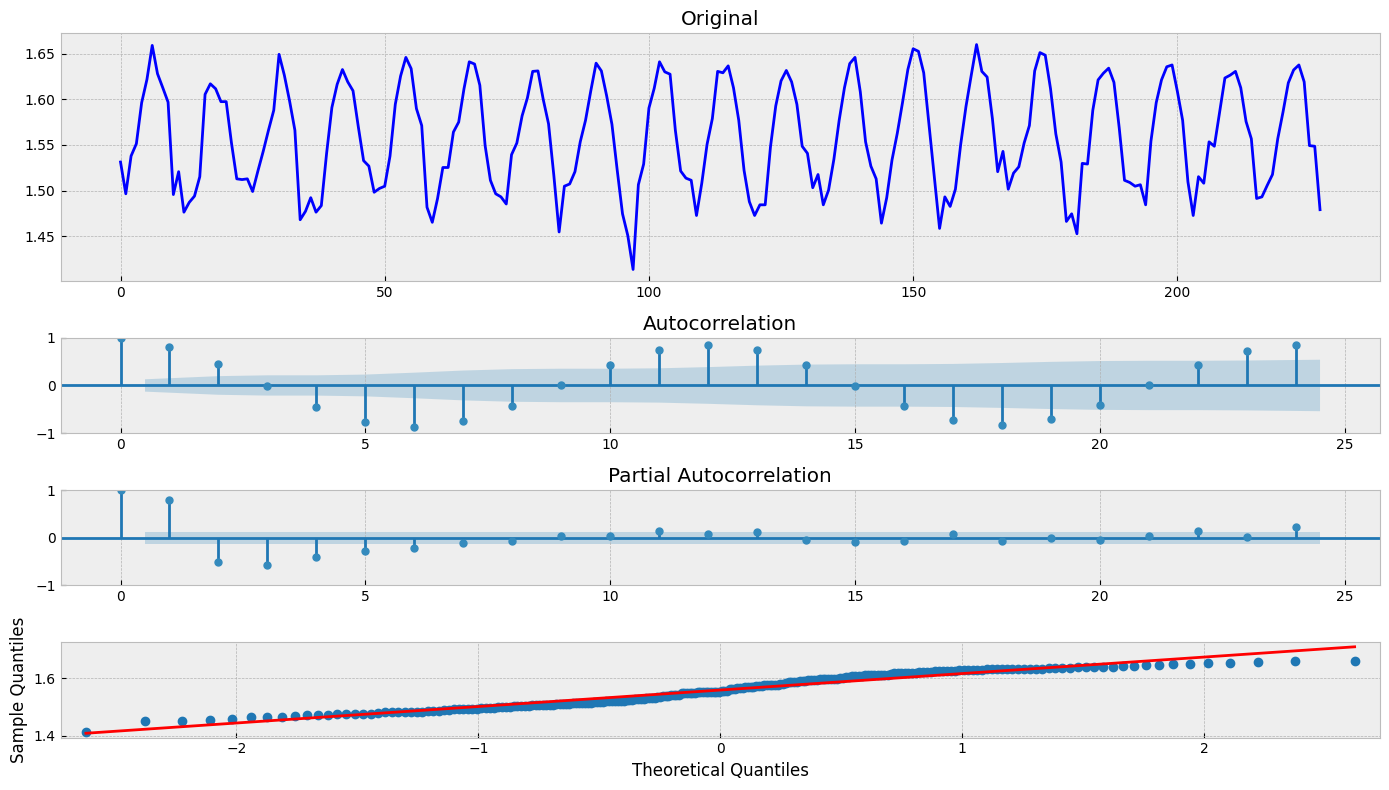

In [17]:
restored_ts = restore_ts(ts_diffed, bc_ts, lmbda)
tsplot(restored_ts)

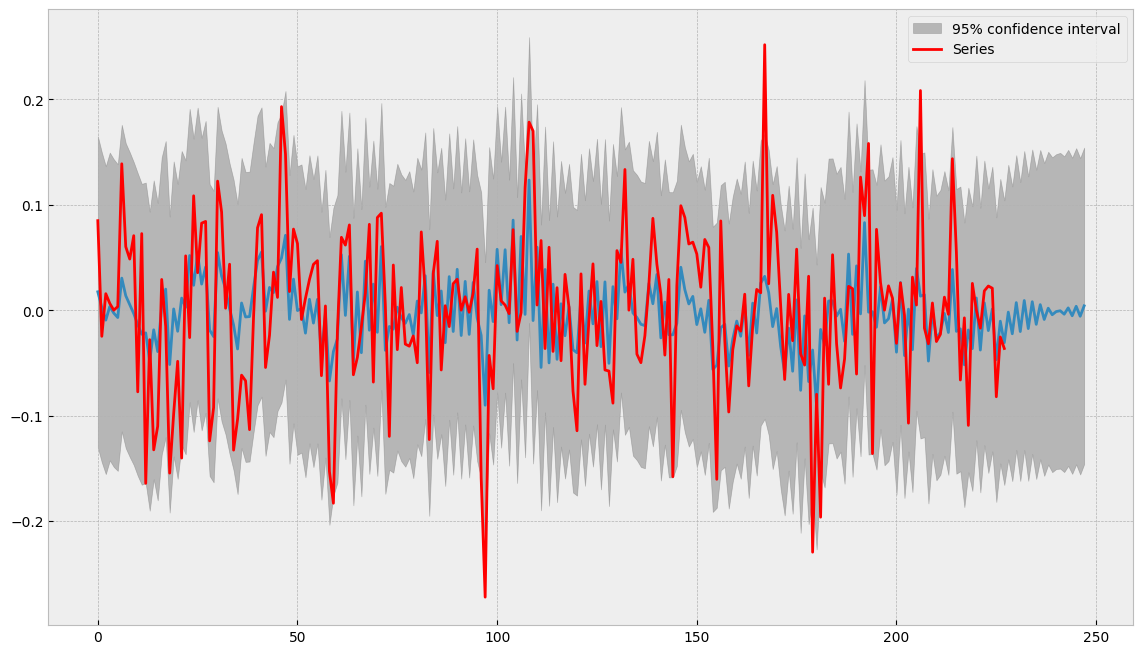

In [11]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(ts_diffed)+20, ax=ax)
    plt.plot(ts_diffed, color='red', label='Series')
    plt.legend()
    plt.show()

### Дополнительное задание*
Попробуйте спрогнозировать график классическим ML.

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
df = pd.DataFrame(ts_diffed, columns=['deg'])
df.head()

,deg
0,0.108658
1,-0.031634
2,0.020079
3,0.008244
4,0.000000


In [43]:
date = pd.to_datetime(pd.read_csv('Series/mean-monthly-air-temperature-deg.csv')['Month'])
df['month'] = date.dt.month
df['year'] = date.dt.year
df.head()

,deg,month,year
0,0.108658,1,1920
1,-0.031634,2,1920
2,0.020079,3,1920
3,0.008244,4,1920
4,0.000000,5,1920


In [51]:
rf = RandomForestRegressor(random_state=42).fit(df[['month', 'year']][:200], df['deg'][:200])

Results of Dickey-Fuller Test:
Test Statistic                  -4.825695
p-value                          0.000049
#Lags Used                      12.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


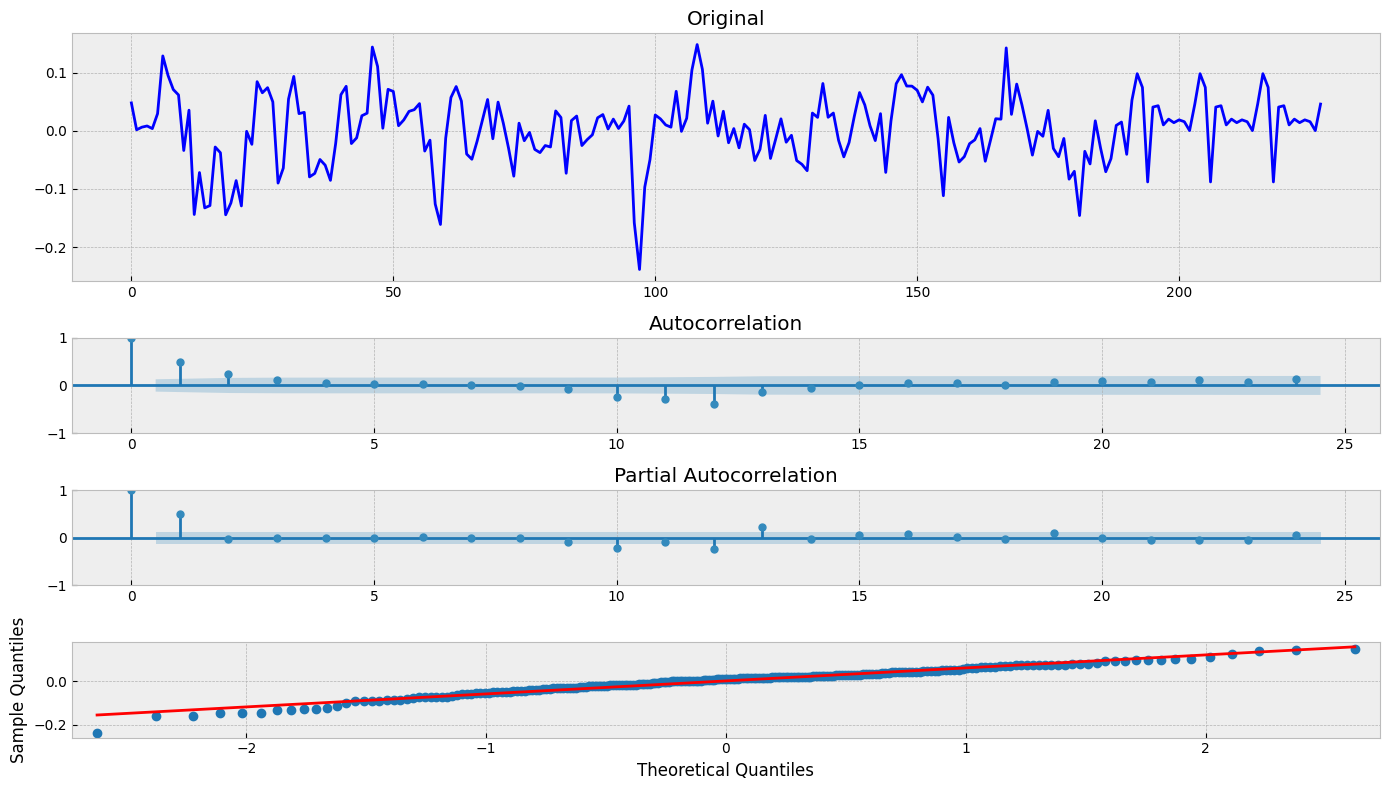

In [54]:
tsplot(rf.predict(df[['month', 'year']]))

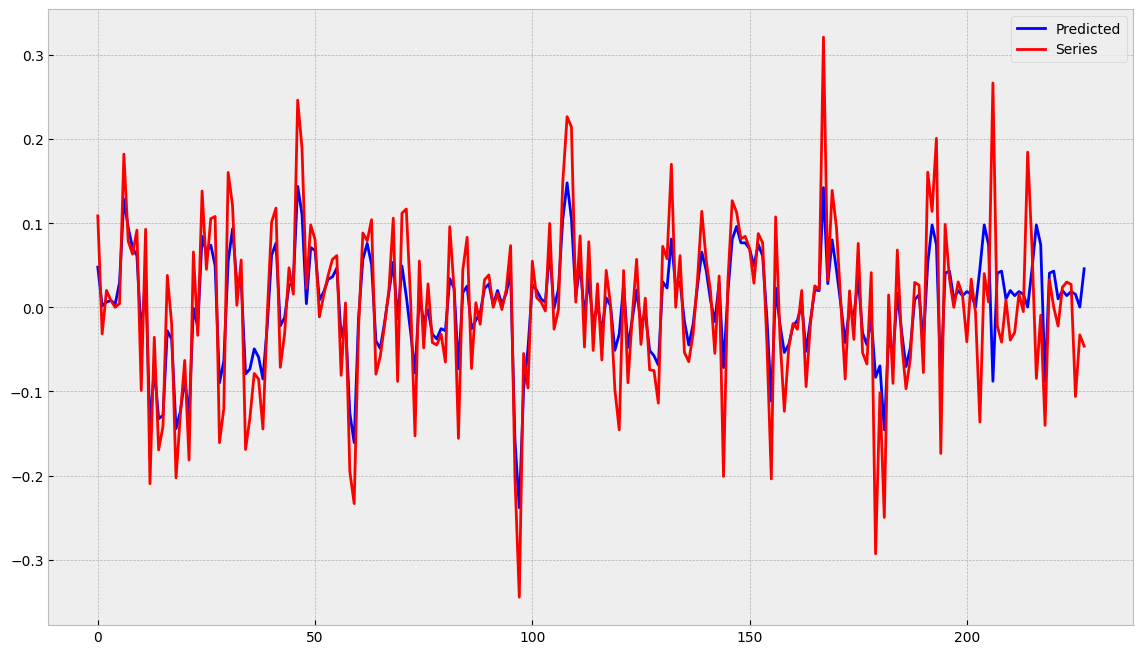

In [53]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(rf.predict(df[['month', 'year']]), color='blue', label='Predicted')
    plt.plot(ts_diffed, color='red', label='Series')
    plt.legend()
    plt.show()